# HuggingFace TimesFM test

In [51]:
# Standard librairy
import os
from pathlib import Path
import gc
from tqdm import tqdm

# Librairies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ML librairies
import torch
import torch.nn as nn

In [52]:
from transformers import (
    TimesFmConfig,
    TimesFmModelForPrediction
)

from transformers import set_seed
set_seed(42)

In [53]:
timesfm = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map="auto",
)

In [54]:
print(f"\nModel: \n{timesfm}")
print("\n-----------------------\n\n")
print(f"Number of parameters: \n{timesfm.num_parameters()/1e6:.2f}M")
print("\n-----------------------\n\n")
print(f"Config: \n{timesfm.config}")


Model: 
TimesFmModelForPrediction(
  (decoder): TimesFmModel(
    (input_ff_layer): TimesFmResidualBlock(
      (input_layer): Linear(in_features=64, out_features=1280, bias=True)
      (activation): SiLU()
      (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
      (residual_layer): Linear(in_features=64, out_features=1280, bias=True)
    )
    (freq_emb): Embedding(3, 1280)
    (layers): ModuleList(
      (0-49): 50 x TimesFmDecoderLayer(
        (self_attn): TimesFmAttention(
          (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (o_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): TimesFmMLP(
          (gate_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (down_proj): Linear(in_features=1280, out_features=1280, bias=True)

In [55]:
# Observations des paramètres du modèle
for name, param in timesfm.named_parameters():
    if param.requires_grad:
        if name.startswith("decoder.layers"):
            if name.startswith("decoder.layers.0"):
                print(f"Parameter: {name} | Size: {param.size()}")
            if name == "decoder.layers.1.self_attn.scaling":
                print("* 50 layers")
            else:
                continue
        else:
            print(f"Parameter: {name} | Size: {param.size()}")

Parameter: decoder.input_ff_layer.input_layer.weight | Size: torch.Size([1280, 64])
Parameter: decoder.input_ff_layer.input_layer.bias | Size: torch.Size([1280])
Parameter: decoder.input_ff_layer.output_layer.weight | Size: torch.Size([1280, 1280])
Parameter: decoder.input_ff_layer.output_layer.bias | Size: torch.Size([1280])
Parameter: decoder.input_ff_layer.residual_layer.weight | Size: torch.Size([1280, 64])
Parameter: decoder.input_ff_layer.residual_layer.bias | Size: torch.Size([1280])
Parameter: decoder.freq_emb.weight | Size: torch.Size([3, 1280])
Parameter: decoder.layers.0.self_attn.scaling | Size: torch.Size([80])
Parameter: decoder.layers.0.self_attn.q_proj.weight | Size: torch.Size([1280, 1280])
Parameter: decoder.layers.0.self_attn.q_proj.bias | Size: torch.Size([1280])
Parameter: decoder.layers.0.self_attn.k_proj.weight | Size: torch.Size([1280, 1280])
Parameter: decoder.layers.0.self_attn.k_proj.bias | Size: torch.Size([1280])
Parameter: decoder.layers.0.self_attn.v_proj

In [56]:
dummy_input = [torch.randn(length).to(torch.bfloat16).to(timesfm.device) for length in [5, 500, 1000, 10000]]
outputs = timesfm(past_values=dummy_input)
print("-----------------------")
print(f"Input len: {len(dummy_input)}")
print(f"Input (first) size: {dummy_input[0].shape}")
print("-----------------------")
print(f"Output: {outputs.keys()}")
print(f"Output (last_hidden) size: {outputs['last_hidden_state'].shape}")
print(f"Output (points) size: {outputs['mean_predictions'].shape}")
print(f"Output (quantiles) size: {outputs['full_predictions'].shape}")


-----------------------
Input len: 4
Input (first) size: torch.Size([5])
-----------------------
Output: odict_keys(['last_hidden_state', 'mean_predictions', 'full_predictions'])
Output (last_hidden) size: torch.Size([4, 64, 1280])
Output (points) size: torch.Size([4, 128])
Output (quantiles) size: torch.Size([4, 128, 10])


In [57]:
# compute the mean of the 64 hidden dimensions for each time step
mean_hidden_0 = outputs["last_hidden_state"][0, :, :].mean(dim=0)
print("\nMean over hidden dimensions at each time step:")
print(mean_hidden_0)
print(mean_hidden_0.shape)
print(" ")
for i in range(outputs["last_hidden_state"].shape[1]):
    print(outputs["last_hidden_state"][0, i])
    print(outputs["last_hidden_state"][0, i].shape)
    # For each, give the rmse compared to the mean over the hidden dimensions
    rmse = torch.sqrt(torch.mean((outputs["last_hidden_state"][0, i] - mean_hidden_0) ** 2))
    print(f"RMSE at time step {i}: {rmse.item()}\n")

print("\n\n\n Conclusion: A lot of hidden states are very close to the mean, but the last deviate significantly.\n\n\n")


Mean over hidden dimensions at each time step:
tensor([-0.4023, -0.3613,  1.0781,  ..., -0.6797,  1.3125, -1.1797],
       device='cuda:1', dtype=torch.bfloat16, grad_fn=<MeanBackward1>)
torch.Size([1280])
 
tensor([-0.4062, -0.3672,  1.0781,  ..., -0.6875,  1.3281, -1.1953],
       device='cuda:1', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)
torch.Size([1280])
RMSE at time step 0: 0.02294921875

tensor([-0.4062, -0.3672,  1.0781,  ..., -0.6875,  1.3281, -1.1953],
       device='cuda:1', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)
torch.Size([1280])
RMSE at time step 1: 0.02294921875

tensor([-0.4062, -0.3672,  1.0781,  ..., -0.6875,  1.3281, -1.1953],
       device='cuda:1', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)
torch.Size([1280])
RMSE at time step 2: 0.02294921875

tensor([-0.4062, -0.3672,  1.0781,  ..., -0.6875,  1.3281, -1.1953],
       device='cuda:1', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)
torch.Size([1280])
RMSE at time step 3: 0.02294921875

ten

In [58]:
del timesfm, dummy_input, outputs, mean_hidden_0, rmse, name, param
gc.collect()
torch.cuda.empty_cache()

### Observe each component of the model: input size, output size, number of parameters

#### Head: Horizon feedforward layer

In [59]:
timesfm = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map="auto",
)

In [60]:
head = timesfm.horizon_ff_layer
print(f"\nHead: \n{head}")
print("\n-----------------------\n\n")
print(f"Number of trainable parameters: \n{sum(p.numel() for p in head.parameters() if p.requires_grad)/1e6:.2f}M")
print(f"Number of parameters: \n{sum(p.numel() for p in head.parameters())/1e6:.2f}M")
print("\n-----------------------\n\n")
print(f"Config: \n{head.config if hasattr(head, 'config') else 'No config available'}")


Head: 
TimesFmResidualBlock(
  (input_layer): Linear(in_features=1280, out_features=1280, bias=True)
  (activation): SiLU()
  (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
  (residual_layer): Linear(in_features=1280, out_features=1280, bias=True)
)

-----------------------


Number of trainable parameters: 
4.92M
Number of parameters: 
4.92M

-----------------------


Config: 
No config available


In [61]:
batch_size = 4
num_patches = 64
decoder_output_dim = 1280
dummy_input = torch.randn(batch_size, num_patches, decoder_output_dim).to(torch.bfloat16).to(timesfm.device)

outputs = head(dummy_input)

print("input shape:", dummy_input.shape)
print("output shape:", outputs.shape)

input shape: torch.Size([4, 64, 1280])
output shape: torch.Size([4, 64, 1280])


In [62]:
del timesfm, dummy_input, outputs
gc.collect()
torch.cuda.empty_cache()

#### Decoder

In [63]:
timesfm = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map="auto",
)

In [64]:
decoder = timesfm.decoder
print(f"\nDecoder: \n{decoder}")
print("\n-----------------------\n\n")
print(f"Number of trainable parameters: \n{sum(p.numel() for p in decoder.parameters() if p.requires_grad)/1e6:.2f}M")
print(f"Number of parameters: \n{sum(p.numel() for p in decoder.parameters())/1e6:.2f}M")
print("\n-----------------------\n\n")
print(f"Config: \n{decoder.config if hasattr(decoder, 'config') else 'No config available'}")


Decoder: 
TimesFmModel(
  (input_ff_layer): TimesFmResidualBlock(
    (input_layer): Linear(in_features=64, out_features=1280, bias=True)
    (activation): SiLU()
    (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
    (residual_layer): Linear(in_features=64, out_features=1280, bias=True)
  )
  (freq_emb): Embedding(3, 1280)
  (layers): ModuleList(
    (0-49): 50 x TimesFmDecoderLayer(
      (self_attn): TimesFmAttention(
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (o_proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (mlp): TimesFmMLP(
        (gate_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (down_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (layer_norm): LayerNorm((1280,), eps=1e-06, elementwise_affine=Tr

In [65]:
# batch_size = 4
# num_patches = 64
# decoder_output_dim = 1280
# dummy_past_values = torch.randn(batch_size, num_patches, decoder_output_dim).to(torch.bfloat16).to(timesfm.device)
# dummy_past_values_padding = torch.zeros(batch_size, num_patches).to(torch.bfloat16).to(timesfm.device)
# dummy_freq = torch.tensor([0, 0, 0, 0]).to(torch.int).to(timesfm.device)
# print("dummy_freq:", dummy_freq)
# 
# outputs = decoder(
#     past_values=dummy_past_values, 
#     past_values_padding=dummy_past_values_padding,
#     freq=dummy_freq
# )
# 
# print("input shape:", dummy_past_values.shape)
# print("output shape:", outputs.shape)

In [66]:
# del dummy_past_values, dummy_past_values_padding, dummy_freq, outputs
# gc.collect()

In [67]:
# dummy_input = torch.randn(4, 64, 1280).to(torch.bfloat16).to(timesfm.device)
# dummy_padding = torch.ones(4, 64, 1280).to(torch.bfloat16).to(timesfm.device)
# dummy_frequency = torch.tensor(0).to(torch.int).to(timesfm.device)
# output = decoder(past_values=dummy_input, past_values_padding=dummy_padding, freq=dummy_frequency)
# print("-----------------------")
# print(f"Input size: {dummy_input.shape}")
# print(f"Output size: {output.shape}")

In [68]:
# del dummy_past_values, dummy_past_values_padding, dummy_freq, outputs, timesfm
# gc.collect()
# torch.cuda.empty_cache()

In [69]:
help(decoder)

Help on TimesFmModel in module transformers.models.timesfm.modeling_timesfm object:

class TimesFmModel(TimesFmPreTrainedModel)
 |  TimesFmModel(config: transformers.models.timesfm.configuration_timesfm.TimesFmConfig)
 |  
 |  The bare Timesfm Model outputting raw hidden-states without any specific head on top.
 |  
 |  This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
 |  library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
 |  etc.)
 |  
 |  This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
 |  Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage
 |  and behavior.
 |  
 |  Parameters:
 |      config ([`TimesFmConfig`]):
 |          Model configuration class with all the parameters of the model. Initializing with a config file does not
 |      

In [70]:
del decoder, timesfm
gc.collect()
torch.cuda.empty_cache()

### Extract encoder features thanks to Pytorch Hooks

In [71]:
class TimesFmFeatureExtractor:
    def __init__(self, model_name="google/timesfm-2.0-500m-pytorch"):
        self.model = TimesFmModelForPrediction.from_pretrained(
            model_name,
            dtype=torch.bfloat16,
            attn_implementation="sdpa",
            device_map="auto",
        )
        
        self.intercepted_features = {}
        self.hook_handle = self._register_hook()
    
    def _register_hook(self):
        """Place the hook on the decoder to intercept its output"""
        
        def decoder_hook(module, input, output):
            """
            This function will be called automatically after the decoder's forward pass
                module: the TimesFmDecoder module
                input: tuple containing the decoder's inputs
                output: the decoder's outputs (what we want to capture)
            """
            self.intercepted_features['decoder_output'] = output["last_hidden_state"].detach().clone()
            return output       # return the output unchanged not to disrupt the forward pass

        hook_handle = self.model.decoder.register_forward_hook(decoder_hook)
        return hook_handle
    
    def extract_features(self, past_values, freq):
        """
        Forward pass through the model to extract features from the decoder.
            past_values: Tensor of shape (batch_size, seq_len)
            freq: Tensor of shape (batch_size,)
        """
        self.intercepted_features.clear()
        
        with torch.no_grad():
            final_output = self.model(
                past_values=past_values,
                freq=freq
            )
            if 'decoder_output' in self.intercepted_features:
                features = self.intercepted_features['decoder_output']
                return features, final_output
            else:
                raise RuntimeError("No features intercepted by the hook")
    
    def __del__(self):
        if hasattr(self, 'hook_handle'):
            self.hook_handle.remove()

In [72]:
extractor = TimesFmFeatureExtractor()

In [73]:
extractor.model.config

TimesFmConfig {
  "architectures": [
    "TimesFmModelForPrediction"
  ],
  "attention_dropout": 0.0,
  "context_length": 2048,
  "dtype": "bfloat16",
  "freq_size": 3,
  "head_dim": 80,
  "hidden_size": 1280,
  "horizon_length": 128,
  "initializer_range": 0.02,
  "intermediate_size": 1280,
  "max_timescale": 10000,
  "min_timescale": 1,
  "model_type": "timesfm",
  "num_attention_heads": 16,
  "num_hidden_layers": 50,
  "pad_val": 1123581321.0,
  "patch_length": 32,
  "quantiles": [
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9
  ],
  "rms_norm_eps": 1e-06,
  "tolerance": 1e-06,
  "transformers_version": "4.56.0",
  "use_positional_embedding": false
}

In [74]:
dummy_past_values = [torch.randn(ts).to(torch.bfloat16).to(extractor.model.device) for ts in [512, 1024, 2049]]
dummy_freq = [torch.tensor([0]).to(extractor.model.device) for _ in range(len(dummy_past_values))]

In [75]:
features, final_output = extractor.extract_features(dummy_past_values, dummy_freq)

In [76]:
print(features)
print(features.shape)

tensor([[[ 4.5312e-01, -1.3359e+00, -4.5703e-01,  ...,  5.2344e-01,
           5.0000e-01, -7.5000e-01],
         [ 4.5312e-01, -1.3359e+00, -4.5703e-01,  ...,  5.2344e-01,
           5.0000e-01, -7.5000e-01],
         [ 4.5312e-01, -1.3359e+00, -4.5703e-01,  ...,  5.2344e-01,
           5.0000e-01, -7.5000e-01],
         ...,
         [-7.8906e-01, -3.8086e-02, -7.2266e-01,  ..., -2.7344e+00,
          -4.5410e-02, -1.4219e+00],
         [ 4.4922e-01,  1.9043e-01,  8.6719e-01,  ..., -2.2344e+00,
          -5.8594e-01, -1.4219e+00],
         [-4.0039e-01, -7.3438e-01,  1.3125e+00,  ..., -2.1719e+00,
          -1.3750e+00, -4.2773e-01]],

        [[ 8.0469e-01, -5.8984e-01, -1.1719e+00,  ...,  6.8359e-01,
           6.0156e-01,  1.4375e+00],
         [ 8.0469e-01, -5.8984e-01, -1.1719e+00,  ...,  6.8359e-01,
           6.0156e-01,  1.4375e+00],
         [ 8.0469e-01, -5.8984e-01, -1.1719e+00,  ...,  6.8359e-01,
           6.0156e-01,  1.4375e+00],
         ...,
         [ 1.4844e+00,  3

In [77]:
print(final_output.keys())

odict_keys(['last_hidden_state', 'mean_predictions', 'full_predictions'])


## Test of the meaningfulness length of feature sequences depending on length of input

It seems that when the input length is little, the feature sequence is not very meaningful: many vectors are identical. When the input length increases, the feature sequence becomes more diverse.

So we will test the RMSE between each feature vector in the sequence and the mean feature vector of the sequence, for different input lengths. The higher the RMSE, the more diverse the feature vectors are.

If we see that finally if there are equal feature vectors, there are automatically equal to the first, we can just compare to the first feature vector instead of the mean.

In [78]:
extractor = TimesFmFeatureExtractor()

In [116]:
def plot_useful_components(features, mode: str = "mean"):
    """
    Plot the first `num_components` useful components from the extracted features.
        features: Tensor of shape (batch_size, seq_len, feature_dim)
        mode: Method to compute useful components ("mean" or "first")
    """
    features = features.float().cpu().numpy()
    batch_size, num_patches, feature_dim = features.shape
    mean_features = features.mean(axis=1)  # shape: (batch_size, feature_dim)

    
    if mode == "mean":
        rmse = np.sqrt(np.mean((features - mean_features[:, np.newaxis, :]) ** 2, axis=2))
    elif mode == "first":
        rmse = np.sqrt(np.mean((features - features[:, 0, :][:, np.newaxis, :]) ** 2, axis=2))
    else:
        raise ValueError("Invalid mode. Choose 'mean' or 'first'.")

        
    plt.figure(figsize=(12, 4))
    plt.imshow(rmse.T, aspect='auto', cmap='viridis')
    plt.colorbar(label='RMSE')
    plt.title(f'RMSE of Features ({mode} mode)')
    plt.xlabel('input length')
    plt.ylabel('correlation btw output and mean feature vector' if mode=="mean" else 'correlation btw output and first feature vector')
    plt.grid()
    plt.show()



In [106]:
dummy_past_values = [torch.randn(ts).to(torch.bfloat16).to(extractor.model.device) for ts in [i+1 for i in range(2300)]]
dummy_freq = [torch.tensor([0]).to(extractor.model.device) for _ in range(len(dummy_past_values))]

In [107]:
features, _ = extractor.extract_features(dummy_past_values, dummy_freq)

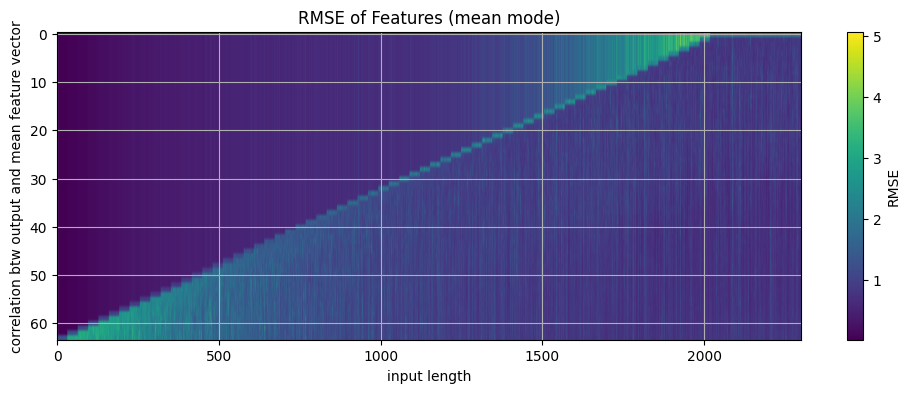

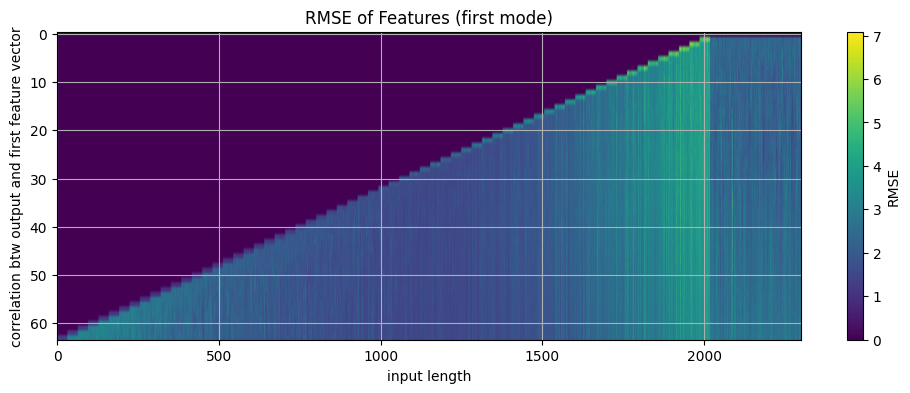

In [117]:
plot_useful_components(features, mode="mean")
plot_useful_components(features, mode="first")

In [109]:
dummy_past_values2 = [torch.ones(ts).to(torch.bfloat16).to(extractor.model.device) for ts in [i+1 for i in range(2300)]]
dummy_freq2 = [torch.tensor([0]).to(extractor.model.device) for _ in range(len(dummy_past_values2))]

In [110]:
features2, _ = extractor.extract_features(dummy_past_values2, dummy_freq2)

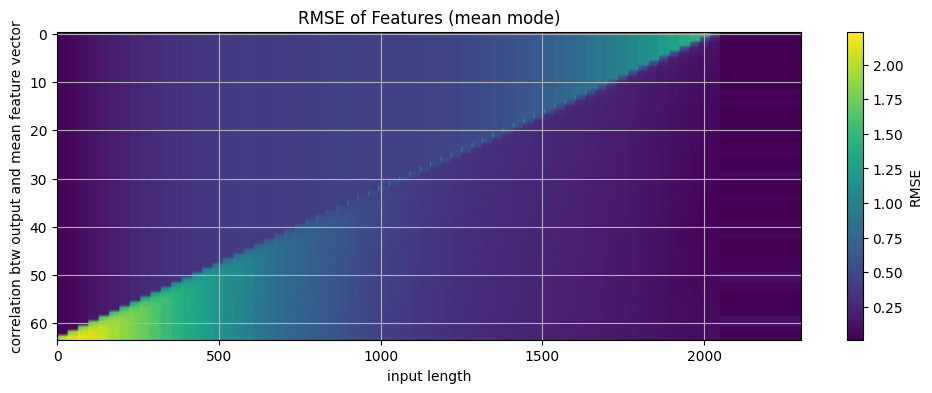

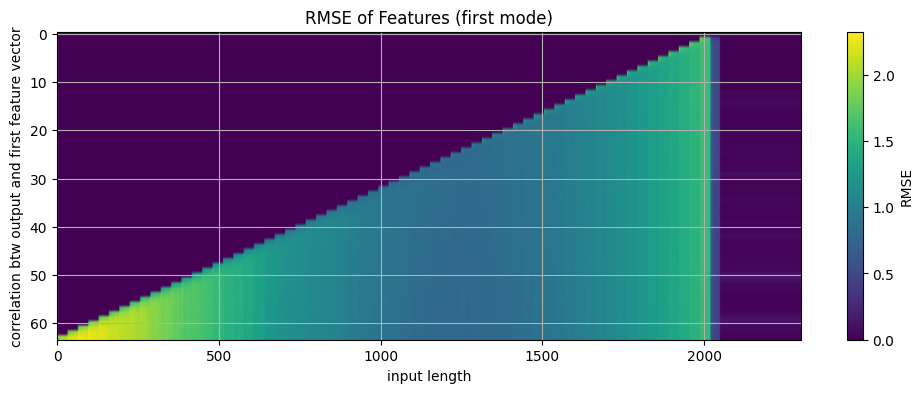

In [118]:
plot_useful_components(features2, mode="mean")
plot_useful_components(features2, mode="first")

### Find for a given input length the number of useful components in the feature sequence.

In [130]:
def number_of_component_to_keep(features, threshold: float = 0.1, mode: str = "mean"):
    """
    Determine the number of useful components to keep based on a threshold.
        features: Tensor of shape (batch_size, seq_len, feature_dim)
        threshold: RMSE threshold to consider a component as useful
        mode: Method to compute useful components ("mean" or "first")
    Returns:
        List of number of components to keep for each input in the batch
    """
    features = features.float().cpu().numpy()
    batch_size, num_patches, feature_dim = features.shape
    mean_features = features.mean(axis=1)  # shape: (batch_size, feature_dim)

    
    if mode == "mean":
        rmse = np.sqrt(np.mean((features - mean_features[:, np.newaxis, :]) ** 2, axis=2))
    elif mode == "first":
        rmse = np.sqrt(np.mean((features - features[:, 0, :][:, np.newaxis, :]) ** 2, axis=2))
    else:
        raise ValueError("Invalid mode. Choose 'mean' or 'first'.")
        
    useful_components = np.sum(rmse > threshold, axis=1).tolist()
    return useful_components


def plot_useful_components(features, threshold: float = 0.1):
    """
    Plot the number of useful components to keep for each input in the batch using the function number_of_component_to_keep in mean and first mode.
        features: Tensor of shape (batch_size, seq_len, feature_dim)
    """
    num_components_mean = number_of_component_to_keep(features, threshold=threshold, mode="mean")
    num_components_first = number_of_component_to_keep(features, threshold=threshold, mode="first")

    print("Assert the first is at least 1 for input size 1:", num_components_first[0])

    plt.figure(figsize=(12, 4))
    plt.plot(num_components_mean, label='Mean Mode', marker='o')
    plt.plot(num_components_first, label='First Mode', marker='x')
    plt.title('Number of Useful Components to Keep')
    plt.xlabel('Input Index in Batch')
    plt.ylabel('Number of Useful Components')
    plt.legend()
    plt.grid()
    plt.show()


In [131]:
dummy_past_values3 = [torch.randn(ts).to(torch.bfloat16).to(extractor.model.device) for ts in [i+1 for i in range(2100)]]
dummy_freq3 = [torch.tensor([0]).to(extractor.model.device) for _ in range(len(dummy_past_values3))]

In [128]:
features3, _ = extractor.extract_features(dummy_past_values3, dummy_freq3)

Assert the first is at least 1 for input size 1: 1


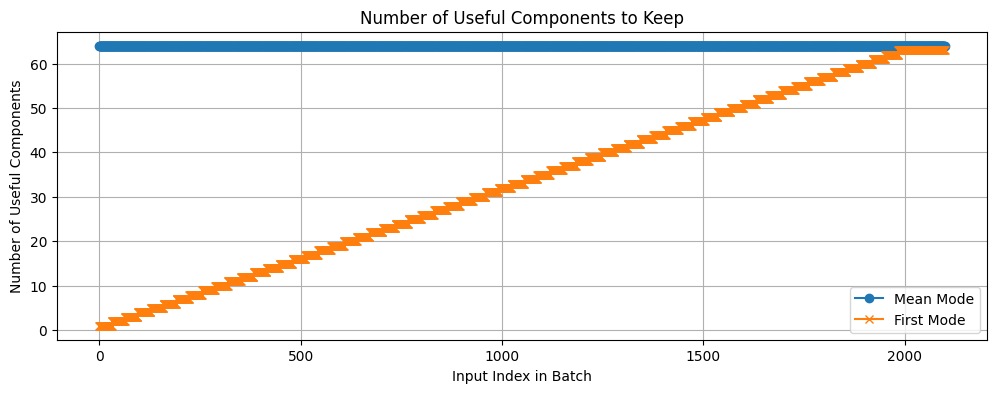

In [132]:
plot_useful_components(features3, threshold=0.001)